# DE analysis with `quickMarkers` from SoupX

(it uses TF-IDF)

Donor P13 data

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
import os
#import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
%%bash

pip freeze

absl-py==0.12.0
aiohttp==3.7.4.post0
airr==1.3.1
alabaster==0.7.12
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1613901514078/work
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1605539061264/work
anndata2ri==1.0.6
annoy @ file:///home/conda/feedstock_root/build_artifacts/python-annoy_1610271511811/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1614388751160/work/dist
arboreto==0.1.6
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522574055/work
astunparse==1.6.3
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1605182336601/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bbknn @ file:///opt/conda/conda-bld/bbknn_1616434096000/work
bleach @ file:///home/conda/feedstock_

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


In [5]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202007_snRNA-seq_MFI/snRNA_seq_MFI_202007_adatas/202012_FINAL_reanalysis_with_souporcell_deconvolution_common_variants/donor_P13_all_samples_analysis_202110/'


## Reading the fully analysed and annotated object wiht all cell types


In [6]:
# raw values
adata_raw = sc.read(save_path + 'adata_raw_filtered.h5ad')

In [7]:
# reading the fully analysed object, final annotation in 'final_annot_all_troph_corrected'
# norm, log tr in .X, all filtered genes
adata = sc.read(save_path + 'adata_P13_scVI_analysed_corr_by_sample_SN_and_multiome_trophoblast_v5_final.h5ad')

In [8]:
adata

AnnData object with n_obs × n_vars = 37675 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'inv_troph_labels_initial', 'louvain_scvi_n_latent_8', 'final_annot_inv_troph', 'louvain_scvi_troph_rest', 'final_annot_all_troph', 'final_annot_inv_troph_corrected', 'final_annot_all_troph_corrected'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', '

In [9]:
# subset to only final nuclei and transfer annotations for DE test
adata_raw = adata_raw[adata.obs_names]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [10]:
adata_raw.obs['final_annot_all_troph_corrected'] = adata.obs.loc[adata_raw.obs_names,'final_annot_all_troph_corrected']

Trying to set attribute `.obs` of view, copying.


_____________________________________________________________________________________________________________________________________________________________

# DE with `quickMarkers` from SoupX

Comparisons:
- All trophoblast: 1-vs-rest

- Additionally out of curiosity: VCT_CCC vs VCT [VCT + VCT_p]

- Additionally for search of stemness markers: VCT_CCC vs VCT_fusing vs VCT (without VCT_p)

- eEVT vs EVT_2

In [11]:
adata_raw.X # is sparse to begin with

<37675x29058 sparse matrix of type '<class 'numpy.float32'>'
	with 101169482 stored elements in Compressed Sparse Row format>

In [12]:
# need to make dense for transition to R
adata_raw.X = adata_raw.X.todense()

In [13]:
import rpy2.rinterface_lib.callbacks
import logging
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri # requires 'pip install anndata2ri'
anndata2ri.activate()
%load_ext rpy2.ipython

dirname: Trying to get version of anndata2ri from dirname /opt/conda/lib/python3.8/site-packages
dirname: Failed; Does not match re.compile('anndata2ri-([\\d.]+?)(?:\\.dev(\\d+))?(?:[_+-]([0-9a-zA-Z.]+))?$')
git: Trying to get version from git in directory /opt/conda/lib/python3.8/site-packages
git: Failed; directory is not managed by git
metadata: Trying to get version for anndata2ri in dir /opt/conda/lib/python3.8/site-packages
metadata: Succeeded


# All cell types: 1-vs-rest comparison

In [16]:
%%R -i adata_raw

library(SingleCellExperiment)
# takes about ? minutes
adata_raw

class: SingleCellExperiment 
dim: 29058 37675 
metadata(0):
assays(1): X
rownames(29058): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(32): gene_ids.0 feature_types.0 ... genome.7 n_cells.7
colnames(37675): ACCTGAAAGGATGGCT-1_Pla_Camb10691970
  CTACAGAAGAGGCTGT-1_WSSS_PLA8810751 ...
  AGCATCACATATGAAG-1_WSSS_PLA8810750 GTCGAATGTTAAGAAC-1_WSSS_PLA8764121
colData names(15): n_genes donor ... is_doublet
  final_annot_all_troph_corrected
reducedDimNames(0):
altExpNames(0):


In [17]:
%%R 

counts <- assay(adata_raw, "X")
rownames(counts) <- rownames(adata_raw)
colnames(counts) <- colnames(adata_raw)

In [18]:
outpath = './quickMarkers_DEGs/'

In [19]:
%%R -i outpath

library(SoupX)

# started at 21:?
print('running quickMarkers')
all_celltypes_markers = quickMarkers(counts, colData(adata_raw)$final_annot_all_troph_corrected, N=100, # for top N genes, otherwise returns all genes that ranked
                                    #FDR=0.01, 
                                     expressCut=0.9 # recommended cutoffs
                                    )
print('done running quickMarkers, writing results')

write.csv(all_celltypes_markers, file = paste0(outpath, '20220214_all_trophoblast_1_vs_all_quickMarkers_DEGs_expressCut_0.9_N_100.csv'), 
          row.names = T, col.names = T, quote = F)

[1] "running quickMarkers"
[1] "done running quickMarkers, writing results"


In [20]:
pd.set_option('display.max_rows', 100)


In [22]:
DE_all_cell_types = pd.read_csv('./quickMarkers_DEGs/20220214_all_trophoblast_1_vs_all_quickMarkers_DEGs_expressCut_0.9_N_100.csv', index_col=1)

In [23]:
#DE_all_cell_types

In [24]:
dotplot_markers = []

for celltype in np.unique(DE_all_cell_types['cluster']):
    curr_subset_DE = DE_all_cell_types[DE_all_cell_types['cluster'] == celltype]
    curr_subset_DE = curr_subset_DE.sort_values(by='qval', axis=0)
    dotplot_markers.append(list(curr_subset_DE.index)[:10])
    
# flatten list
dotplot_markers = [item for sublist in dotplot_markers for item in sublist]

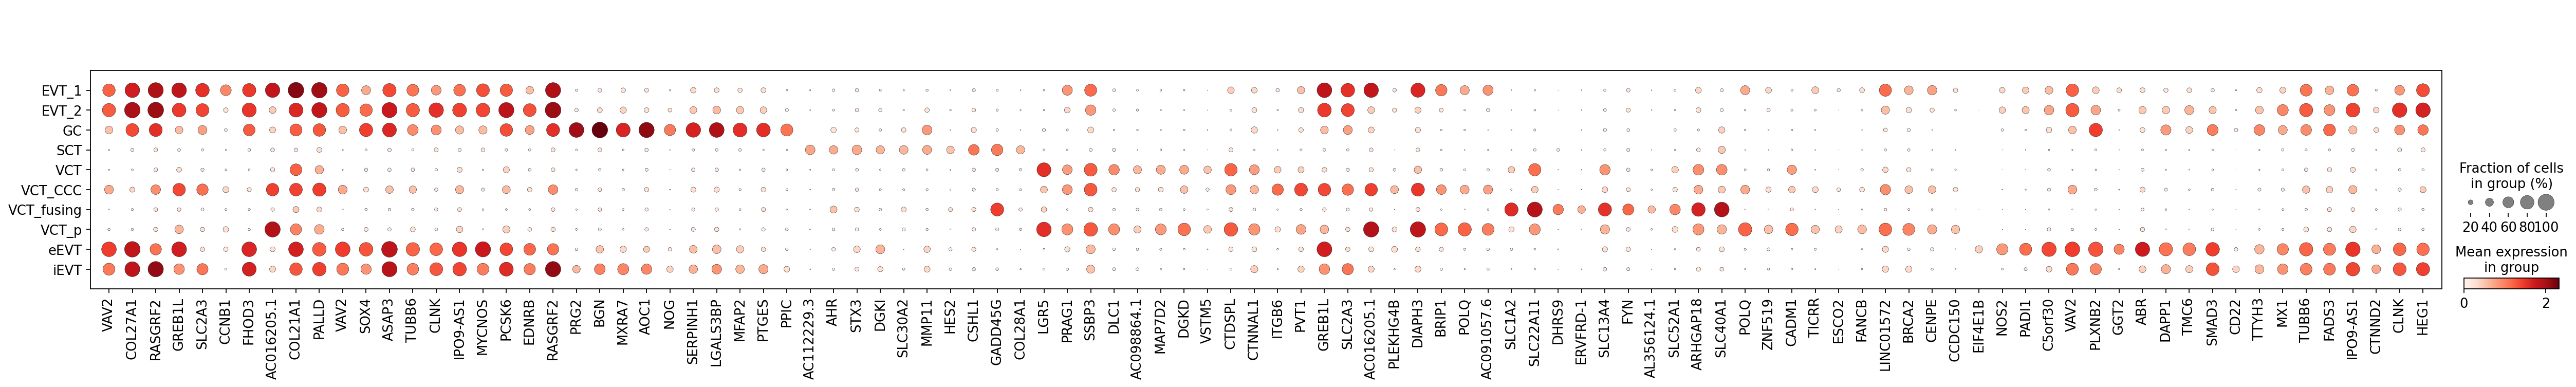

In [25]:
# producing dotplot with adata where data is normalised and log transformed
sc.pl.dotplot(adata, var_names=dotplot_markers, 
              groupby='final_annot_all_troph_corrected', 
              #use_raw=True,
              save='_top_10_TFIDF_markers_all_troph_P13.pdf'
             )

# Additionally: VCT_CCC vs VCT [VCT + VCT_p]

In [11]:
# unite VCT and VCT_p here
adata_raw.obs['final_annot_all_troph_corrected_united_VCT_and_VCT_p'] = ['VCT' if ct in ['VCT','VCT_p'] else ct for ct in adata_raw.obs['final_annot_all_troph_corrected']]


In [12]:
adata_raw.obs['final_annot_all_troph_corrected_united_VCT_and_VCT_p'].value_counts()

SCT           22869
VCT            9560
iEVT           1975
VCT_CCC        1016
EVT_2           883
EVT_1           720
VCT_fusing      523
eEVT             71
GC               58
Name: final_annot_all_troph_corrected_united_VCT_and_VCT_p, dtype: int64

In [13]:
# subset to only populations of interest here
adata_raw_subset = adata_raw[adata_raw.obs['final_annot_all_troph_corrected_united_VCT_and_VCT_p'].isin(['VCT','VCT_CCC'])]

In [14]:
adata_raw_subset.obs['final_annot_all_troph_corrected_united_VCT_and_VCT_p'].value_counts()

VCT        9560
VCT_CCC    1016
Name: final_annot_all_troph_corrected_united_VCT_and_VCT_p, dtype: int64

In [21]:
%%R -i adata_raw_subset

library(SingleCellExperiment)
# takes about ? minutes
adata_raw_subset

class: SingleCellExperiment 
dim: 29058 10576 
metadata(0):
assays(1): X
rownames(29058): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(32): gene_ids.0 feature_types.0 ... genome.7 n_cells.7
colnames(10576): CTACAGAAGAGGCTGT-1_WSSS_PLA8810751
  GACATCATCTAGATCG-1_Pla_Camb10691970 ...
  TGCGGGTCATAATCGC-1_WSSS_PLA8810751 CGATGCGCAATTGCCA-1_WSSS_PLA8810751
colData names(16): n_genes donor ... final_annot_all_troph_corrected
  final_annot_all_troph_corrected_united_VCT_and_VCT_p
reducedDimNames(0):
altExpNames(0):


In [22]:
%%R 

counts <- assay(adata_raw_subset, "X")
rownames(counts) <- rownames(adata_raw_subset)
colnames(counts) <- colnames(adata_raw_subset)

In [23]:
outpath = './quickMarkers_DEGs/'

In [24]:
%%R -i outpath

library(SoupX)

# started at 21:?
print('running quickMarkers')
all_celltypes_markers = quickMarkers(counts, colData(adata_raw_subset)$final_annot_all_troph_corrected_united_VCT_and_VCT_p, N=500, # for top N genes, otherwise returns all genes that ranked
                                    #FDR=0.01, 
                                     expressCut=0.9 # recommended cutoffs
                                    )
print('done running quickMarkers, writing results')

write.csv(all_celltypes_markers, file = paste0(outpath, '20220216_VCT_CCC_vs_VCT_quickMarkers_DEGs_expressCut_0.9_N_500.csv'), 
          row.names = T, col.names = T, quote = F)

[1] "running quickMarkers"
[1] "done running quickMarkers, writing results"


In [25]:
pd.set_option('display.max_rows', 100)


In [15]:
DE_VCT_CCC_vs_VCT = pd.read_csv('./quickMarkers_DEGs/20220216_VCT_CCC_vs_VCT_quickMarkers_DEGs_expressCut_0.9_N_500.csv', index_col=1)

In [16]:
DE_VCT_CCC_vs_VCT

,Unnamed: 0,cluster,geneFrequency,geneFrequencyOutsideCluster,geneFrequencySecondBest,geneFrequencyGlobal,secondBestClusterName,tfidf,idf,qval
gene,,,,,,,,,,
GSTA3,GSTA3,VCT,0.399477,0.074803,0.074803,0.368287,VCT_CCC,0.399035,0.998894,7.705421e-111
NRCAM,NRCAM,VCT,0.376778,0.094488,0.094488,0.349660,VCT_CCC,0.395917,1.050795,1.049237e-83
SEL1L3,SEL1L3,VCT,0.427824,0.102362,0.102362,0.396558,VCT_CCC,0.395709,0.924932,9.432925e-104
LINC01725,LINC01725,VCT,0.407845,0.129921,0.129921,0.381146,VCT_CCC,0.393396,0.964573,7.815609e-75
HIPK2,HIPK2,VCT,0.376046,0.127953,0.127953,0.352213,VCT_CCC,0.392412,1.043520,5.782519e-62
...,...,...,...,...,...,...,...,...,...,...
PTN,PTN,VCT_CCC,0.300197,0.217364,0.217364,0.225321,VCT,0.447361,1.490227,8.216763e-08
H2AFZ,H2AFZ,VCT_CCC,0.295276,0.211925,0.211925,0.219932,VCT,0.447176,1.514437,5.241762e-08
EIF4G1,EIF4G1,VCT_CCC,0.356299,0.277615,0.277615,0.285174,VCT,0.447033,1.254656,2.521352e-06


In [17]:
#DE_all_cell_types

In [18]:
dotplot_markers = []

for celltype in np.unique(DE_VCT_CCC_vs_VCT['cluster']):
    curr_subset_DE = DE_VCT_CCC_vs_VCT[DE_VCT_CCC_vs_VCT['cluster'] == celltype]
    curr_subset_DE = curr_subset_DE.sort_values(by='qval', axis=0)
    dotplot_markers.append(list(curr_subset_DE.index)[:50])
    
# flatten list
dotplot_markers = [item for sublist in dotplot_markers for item in sublist]

In [19]:
adata.obs['final_annot_all_troph_corrected_united_VCT_and_VCT_p'] = adata_raw.obs.loc[adata.obs_names,
                                                                                      'final_annot_all_troph_corrected_united_VCT_and_VCT_p']

... storing 'final_annot_all_troph_corrected_united_VCT_and_VCT_p' as categorical


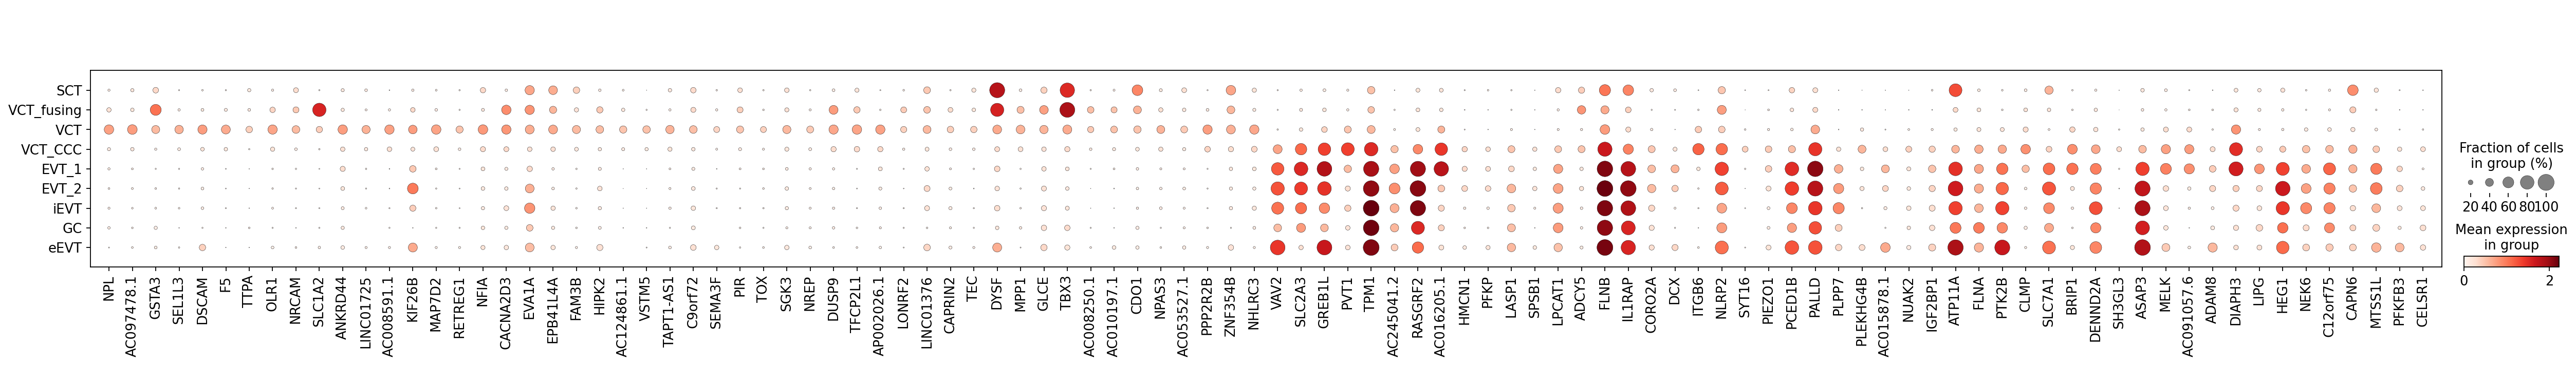

In [20]:
# producing dotplot with adata where data is normalised and log transformed
sc.pl.dotplot(adata, var_names=dotplot_markers, 
              groupby='final_annot_all_troph_corrected_united_VCT_and_VCT_p', 
              categories_order = ['SCT','VCT_fusing','VCT','VCT_CCC','EVT_1','EVT_2','iEVT','GC','eEVT']
              #use_raw=True,
              #save='_top_10_TFIDF_markers_all_troph_P13.pdf'
             )

# Additionally for search of stemness markers: 1-vs-rest comparison in VCT (without VCT_p), VCT_fusing and VCT_CCC

In [14]:
# subset to only populations of interest here
adata_raw_subset = adata_raw[adata_raw.obs['final_annot_all_troph_corrected'].isin(['VCT','VCT_CCC','VCT_fusing'])]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [15]:
adata_raw_subset.obs['final_annot_all_troph_corrected'].value_counts()

VCT           7560
VCT_CCC       1016
VCT_fusing     523
Name: final_annot_all_troph_corrected, dtype: int64

In [16]:
%%R -i adata_raw_subset

library(SingleCellExperiment)
# takes about ? minutes
adata_raw_subset

class: SingleCellExperiment 
dim: 29058 9099 
metadata(0):
assays(1): X
rownames(29058): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(32): gene_ids.0 feature_types.0 ... genome.7 n_cells.7
colnames(9099): CTACAGAAGAGGCTGT-1_WSSS_PLA8810751
  GACATCATCTAGATCG-1_Pla_Camb10691970 ...
  TGCGGGTCATAATCGC-1_WSSS_PLA8810751 CGATGCGCAATTGCCA-1_WSSS_PLA8810751
colData names(15): n_genes donor ... is_doublet
  final_annot_all_troph_corrected
reducedDimNames(0):
altExpNames(0):


In [17]:
%%R 

counts <- assay(adata_raw_subset, "X")
rownames(counts) <- rownames(adata_raw_subset)
colnames(counts) <- colnames(adata_raw_subset)

In [18]:
outpath = './quickMarkers_DEGs/'

In [19]:
%%R -i outpath

library(SoupX)

# started at 21:?
print('running quickMarkers')
all_celltypes_markers = quickMarkers(counts, colData(adata_raw_subset)$final_annot_all_troph_corrected, N=500, # for top N genes, otherwise returns all genes that ranked
                                    #FDR=0.01, 
                                     expressCut=0.9 # recommended cutoffs
                                    )
print('done running quickMarkers, writing results')

write.csv(all_celltypes_markers, file = paste0(outpath, '20220216_VCT_vs_VCT_fusing_vs_VCT_CCC_quickMarkers_DEGs_expressCut_0.9_N_500.csv'), 
          row.names = T, col.names = T, quote = F)

[1] "running quickMarkers"
[1] "done running quickMarkers, writing results"


In [20]:
pd.set_option('display.max_rows', 100)


In [6]:
DE_all_cell_types = pd.read_csv('./quickMarkers_DEGs/20220216_VCT_vs_VCT_fusing_vs_VCT_CCC_quickMarkers_DEGs_expressCut_0.9_N_500.csv', index_col=1)


In [7]:
#DE_all_cell_types

In [8]:
dotplot_markers = []

for celltype in np.unique(DE_all_cell_types['cluster']):
    curr_subset_DE = DE_all_cell_types[DE_all_cell_types['cluster'] == celltype]
    curr_subset_DE = curr_subset_DE.sort_values(by='qval', axis=0)
    dotplot_markers.append(list(curr_subset_DE.index)[:100])
    
# flatten list
dotplot_markers = [item for sublist in dotplot_markers for item in sublist]

In [30]:
adata_subset = adata[adata.obs['final_annot_all_troph_corrected'].isin(['VCT','VCT_fusing','VCT_CCC'])].copy()

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


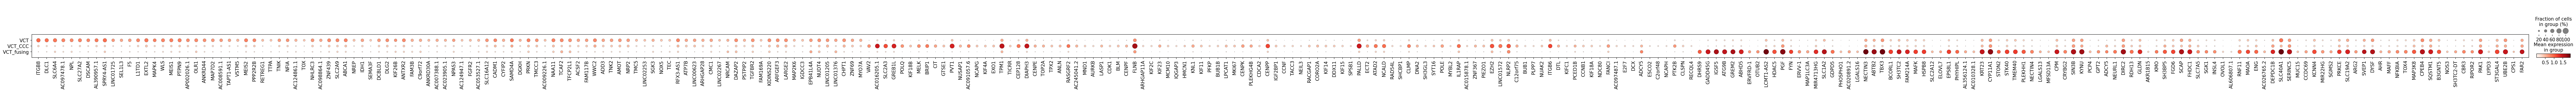

In [31]:
# producing dotplot with adata where data is normalised and log transformed
sc.pl.dotplot(adata_subset, var_names=dotplot_markers, 
              groupby='final_annot_all_troph_corrected', 
              #use_raw=True,
              save='_top_100_TFIDF_markers_VCT_vs_VCT_CCC_vs_VCT_fusing_P13.pdf'
             )

In [9]:
# also plotting these markers in in vitro dataset counterpart - VCT, VCT_CCC and VCT_fusing
adata_organoids = sc.read('/lustre/scratch117/cellgen/team292/aa22/adata_objects/202105_troph_organoids_exp_1_2/adata_scVI_analysed_no_cytokines_after_scVI_with_gene_filter_and_excluding_filter_mix_cluster.h5ad')


In [10]:
np.unique(adata_organoids.obs['final_annot_v9'])

array(['EVT_1_like', 'EVT_early', 'EVT_late', 'EVT_mid', 'SCT', 'VCT',
       'VCT_CCC', 'VCT_fusing', 'VCT_p', 'iEVT'], dtype=object)

In [11]:
adata_organoids_subset = adata_organoids[adata_organoids.obs['final_annot_v9'].isin(['VCT','VCT_CCC','VCT_fusing'])]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


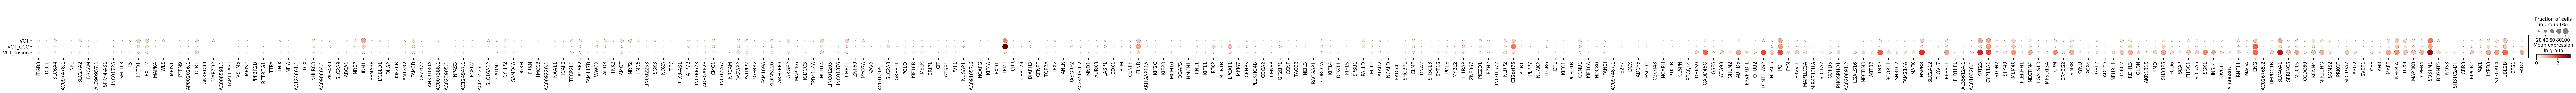

In [15]:
# producing dotplot with adata where data is normalised and log transformed
sc.pl.dotplot(adata_organoids_subset, var_names=[gene for gene in dotplot_markers if gene in adata_organoids_subset.var_names], 
              groupby='final_annot_v9', 
              #use_raw=True,
              save='_top_100_TFIDF_markers_VCT_vs_VCT_CCC_vs_VCT_fusing_in_vitro_organoids.pdf'
             )

# eEVT vs EVT_2

In [15]:
# subset to only populations of interest here
adata_raw_subset = adata_raw[adata_raw.obs['final_annot_all_troph_corrected'].isin(['eEVT','EVT_2'])]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [16]:
adata_raw_subset.obs['final_annot_all_troph_corrected'].value_counts()

EVT_2    883
eEVT      71
Name: final_annot_all_troph_corrected, dtype: int64

In [17]:
%%R -i adata_raw_subset

library(SingleCellExperiment)
# takes about ? minutes
adata_raw_subset

class: SingleCellExperiment 
dim: 29058 954 
metadata(0):
assays(1): X
rownames(29058): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(32): gene_ids.0 feature_types.0 ... genome.7 n_cells.7
colnames(954): TTGTGGATCAACCTTT-1_Pla_Camb10691971
  ATACTTCGTATTGACC-1_WSSS_PLA8764122 ...
  CATTATCTCTAACCTT-1_Pla_Camb10714920_and_40110_Pla_Camb10687916
  TTACAGCAGGAAACTG-1_Pla_Camb10714920_and_40110_Pla_Camb10687916
colData names(15): n_genes donor ... is_doublet
  final_annot_all_troph_corrected
reducedDimNames(0):
altExpNames(0):


In [18]:
%%R 

counts <- assay(adata_raw_subset, "X")
rownames(counts) <- rownames(adata_raw_subset)
colnames(counts) <- colnames(adata_raw_subset)

In [19]:
outpath = './quickMarkers_DEGs/'

In [20]:
%%R -i outpath

library(SoupX)

# started at 21:?
print('running quickMarkers')
all_celltypes_markers = quickMarkers(counts, colData(adata_raw_subset)$final_annot_all_troph_corrected, N=500, # for top N genes, otherwise returns all genes that ranked
                                    #FDR=0.01, 
                                     expressCut=0.9 # recommended cutoffs
                                    )
print('done running quickMarkers, writing results')

write.csv(all_celltypes_markers, file = paste0(outpath, '20220219_eEVT_vs_EVT_2_quickMarkers_DEGs_expressCut_0.9_N_500.csv'), 
          row.names = T, col.names = T, quote = F)

[1] "running quickMarkers"
[1] "done running quickMarkers, writing results"


In [21]:
pd.set_option('display.max_rows', 100)


In [22]:
DE_all_cell_types = pd.read_csv('./quickMarkers_DEGs/20220219_eEVT_vs_EVT_2_quickMarkers_DEGs_expressCut_0.9_N_500.csv', index_col=1)


In [23]:
#DE_all_cell_types

In [24]:
dotplot_markers = []

for celltype in np.unique(DE_all_cell_types['cluster']):
    curr_subset_DE = DE_all_cell_types[DE_all_cell_types['cluster'] == celltype]
    curr_subset_DE = curr_subset_DE.sort_values(by='qval', axis=0)
    dotplot_markers.append(list(curr_subset_DE.index)[:100])
    
# flatten list
dotplot_markers = [item for sublist in dotplot_markers for item in sublist]

In [26]:
#adata_subset = adata[adata.obs['final_annot_all_troph_corrected'].isin(['eEVT','EVT_2'])].copy()

In [ ]:
# producing dotplot with adata where data is normalised and log transformed
sc.pl.dotplot(adata, var_names=dotplot_markers[:100], 
              groupby='final_annot_all_troph_corrected', 
              #use_raw=True,
              save='_top_100_TFIDF_markers_eEVT_vs_EVT_2_P13.pdf'
             )

In [9]:
# also plotting these markers in in vitro dataset counterpart - VCT, VCT_CCC and VCT_fusing
adata_organoids = sc.read('/lustre/scratch117/cellgen/team292/aa22/adata_objects/202105_troph_organoids_exp_1_2/adata_scVI_analysed_no_cytokines_after_scVI_with_gene_filter_and_excluding_filter_mix_cluster.h5ad')


In [10]:
np.unique(adata_organoids.obs['final_annot_v9'])

array(['EVT_1_like', 'EVT_early', 'EVT_late', 'EVT_mid', 'SCT', 'VCT',
       'VCT_CCC', 'VCT_fusing', 'VCT_p', 'iEVT'], dtype=object)

In [11]:
adata_organoids_subset = adata_organoids[adata_organoids.obs['final_annot_v9'].isin(['VCT','VCT_CCC','VCT_fusing'])]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


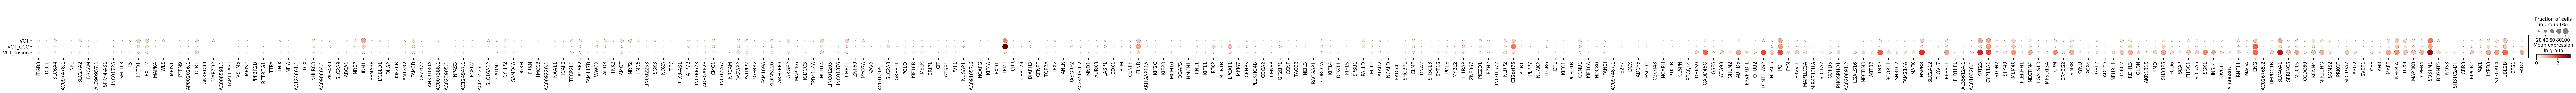

In [15]:
# producing dotplot with adata where data is normalised and log transformed
sc.pl.dotplot(adata_organoids_subset, var_names=[gene for gene in dotplot_markers if gene in adata_organoids_subset.var_names], 
              groupby='final_annot_v9', 
              #use_raw=True,
              save='_top_100_TFIDF_markers_VCT_vs_VCT_CCC_vs_VCT_fusing_in_vitro_organoids.pdf'
             )